# Import

In [22]:
import opendatasets as od

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)


# Load Data

In [2]:
od.download("https://www.kaggle.com/competitions/seoultech-applied-ai-machine-learning1/data")

Skipping, found downloaded files in ".\seoultech-applied-ai-machine-learning1" (use force=True to force download)


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# train data, test data set 가져오기
train_data = np.load('seoultech-applied-ai-machine-learning1/train.npy', allow_pickle='TRUE')
test_data = np.load('seoultech-applied-ai-machine-learning1/test.npy', allow_pickle='TRUE')

In [5]:
print(type(train_data))     # 타입 확인
print(train_data)           # 실제 값 출력

<class 'numpy.ndarray'>
{'input': array([[[[-2.8890e+00],
         [-7.9550e+00],
         [-1.6170e+00],
         ...,
         [ 1.9430e+00],
         [-3.0920e+00],
         [-1.7090e+00]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.6170e+00],
         ...,
         [ 2.9200e+00],
         [-3.0920e+00],
         [ 2.4400e-01]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.5300e-01],
         ...,
         [ 3.4080e+00],
         [-3.0920e+00],
         [ 2.1970e+00]],

        ...,

        [[ 5.9000e+00],
         [ 3.7640e+00],
         [-8.9420e+00],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-1.9775e+01]],

        [[ 5.4120e+00],
         [ 3.2760e+00],
         [-1.0895e+01],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-2.1240e+01]],

        [[ 5.9000e+00],
         [ 2.7870e+00],
         [-1.1383e+01],
         ...,
         [-1.0000e-02],
         [ 5.6970e+00],
         [-2.2217e

In [6]:
# nparray를 list로 변환

train_data = train_data.tolist()
test_data = test_data.tolist()

In [7]:
# 학습 데이터에서 입력(input)과 정답(label) 데이터를 각각 분리
train_input_data = train_data['input']
train_label_data = train_data['label']

In [8]:
# 테스트 데이터에서 입력(input)만 추출하여 배열에 저장
test_input_data = test_data['input']

In [9]:
# data shape 확인
print("train input data shape :", train_input_data.shape)
print("train label data shape :", train_label_data.shape)
print("test input data shape :", test_input_data.shape)

train input data shape : (1080, 256, 64, 1)
train label data shape : (1080,)
test input data shape : (120, 256, 64, 1)


In [10]:
# 의미없는 차원 제거, 3차원 데이터로 변환
train_input_data = train_input_data.reshape(1080, 256, 64)
test_input_data = test_input_data.reshape(120, 256, 64)

print("changed train input data shape :", train_input_data.shape)
print("changed test input data shape :", test_input_data.shape)

changed train input data shape : (1080, 256, 64)
changed test input data shape : (120, 256, 64)


##### 가공된 데이터 배열의 구조에 대한 추측:
첫 번째 값: 전체 데이터 수 (뇌파 측정에 참여한 사람 수)\
두 번째 값: 샘플링 주기 (256Hz)\
세 번째 값: EEG 측정에 사용된 전극 수 (64채널)

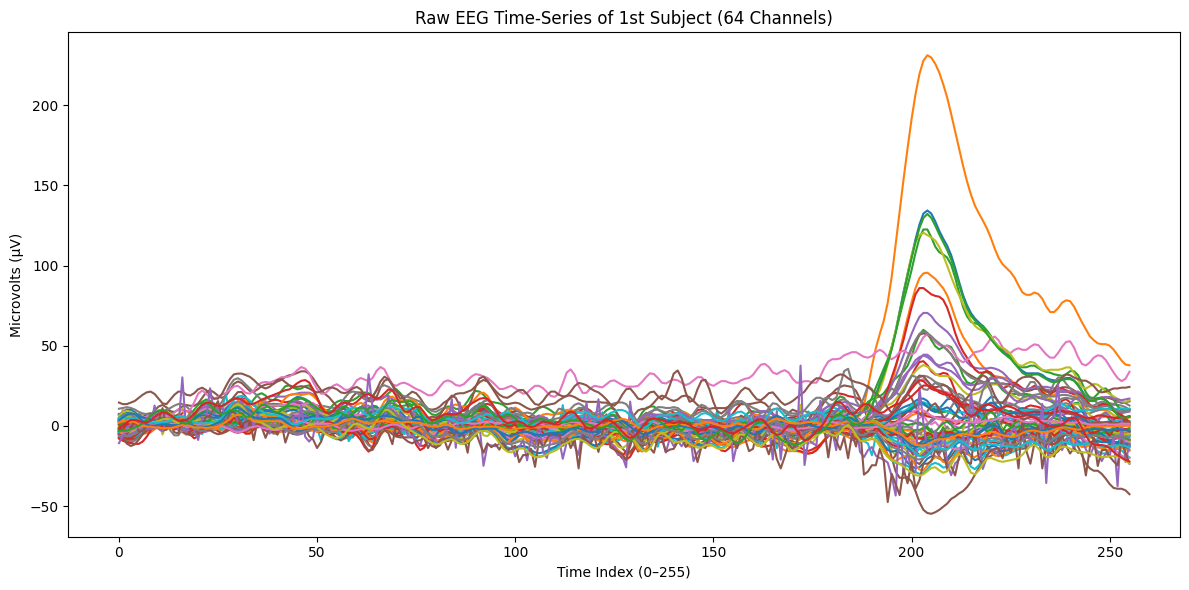

In [11]:
# 1번째 참가자의 EEG 시계열 데이터를 시각화 해보기
list_1 = []

# 샘플링 포인트 (0 ~ 255)
time_points = np.arange(256)

# 1번째 참가자의 데이터 (형태: [256, 64])
sample = train_input_data[0]

plt.figure(figsize=(12, 6))
for channel in range(64):
    signal = sample[:, channel]  # 해당 채널의 시계열 데이터 (256 시점)
    plt.plot(time_points, signal)

plt.title("Raw EEG Time-Series of 1st Subject (64 Channels)")
plt.xlabel("Time Index (0–255)")
plt.ylabel("Microvolts (μV)")
plt.tight_layout()
plt.show()

하지만 우리가 궁극적으로 분석하고자 하는 것은 시간 축의 샘플링 데이터가 아니라, 뇌파의 주파수별 에너지 분포(Power) 이다.

따라서 시간 도메인 데이터를 고속 푸리에 변환(FFT) 을 통해 주파수 도메인으로 변환하고,

0~100Hz 구간의 주파수별 전력 스펙트럼 밀도(PSD, Power Spectral Density) 를 계산하여 시각화해봤다.

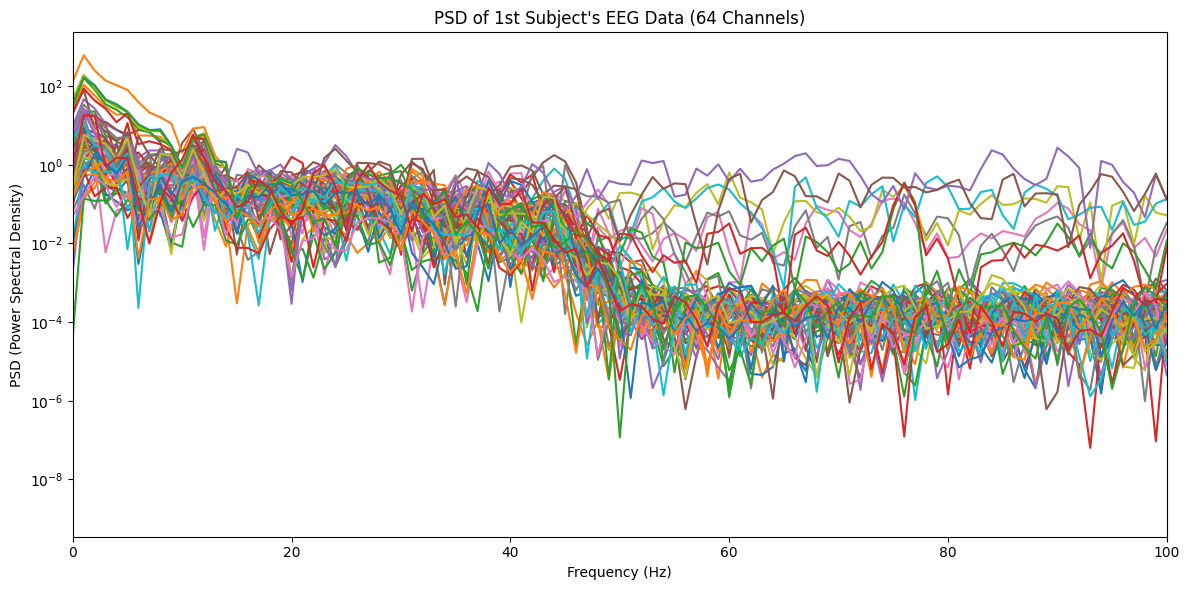

In [12]:
# Welch 방법을 이용해 1번 참가자의 EEG 데이터를 주파수 영역(0~100Hz)으로 변환하여 시각화
# 총 64개의 EEG 채널 각각에 대해 power spectral density(PSD)를 계산하고 시각화함

fs = 256 # 샘플링 주기 (Hz)

# 1번째 참가자의 EEG 데이터를 시각화
participant_index = 0
sample = train_input_data[participant_index]  # shape: (256, 64) - 256 시점, 64채널

plt.figure(figsize=(12, 6))
for channel in range(64):
    signal = sample[:, channel]  # 해당 채널의 1초 분량 시계열 (256 시점)
    f, S = scipy.signal.welch(signal, fs, nperseg=256, scaling='density')
    plt.semilogy(f, S)  # 로그 스케일로 PSD 플롯
    plt.xlim([0, 100])  # 0 ~ 100Hz 범위로 제한

plt.title("PSD of 1st Subject's EEG Data (64 Channels)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (Power Spectral Density)")
plt.tight_layout()
plt.show()

여기서, 세 가지의 데이터 전처리 과정이 필요하다.

1. 이상치(Outlier) 필터링
현재 수집된 EEG 데이터에는 센서 노이즈나 외부 간섭 등으로 인해 이상치가 포함되어 있을 가능성이 있다.
실제로 앞서 시각화한 주파수 그래프를 보면, 45Hz를 초과하는 구간에서 큰 편차가 나타나는 것을 확인할 수 있다. 이를 노이즈로 간주하고, 0~45Hz 구간까지만을 유효 데이터로 사용한다.
 

2. 주파수 대역별 뇌파 특징 추출
EEG 신호는 일반적으로 아래의 5가지 뇌파 주파수 대역으로 구분되며, 각 대역은 서로 다른 인지/정신 상태와 관련이 있다:

    - Delta: 1 ~ 3Hz

    - Theta: 4 ~ 7Hz

    - Alpha: 8 ~ 13Hz

    - Beta: 14 ~ 30Hz

    - Gamma: 31 ~ 45Hz

각 채널(총 64개 전극)에 대해 이 5개 주파수 대역별 전력 스펙트럼 밀도(PSD)의 중앙값을 추출한다.
중앙값(median)을 사용하는 이유는, 이상치의 영향을 최소화하고 중심 경향성을 잘 반영하기 위함이다.

결과적으로, 1명의 참가자에 대해 5개 대역 × 64채널 = 320개의 특징값을 갖는 벡터로 변환된다.


# Data Preprocessing

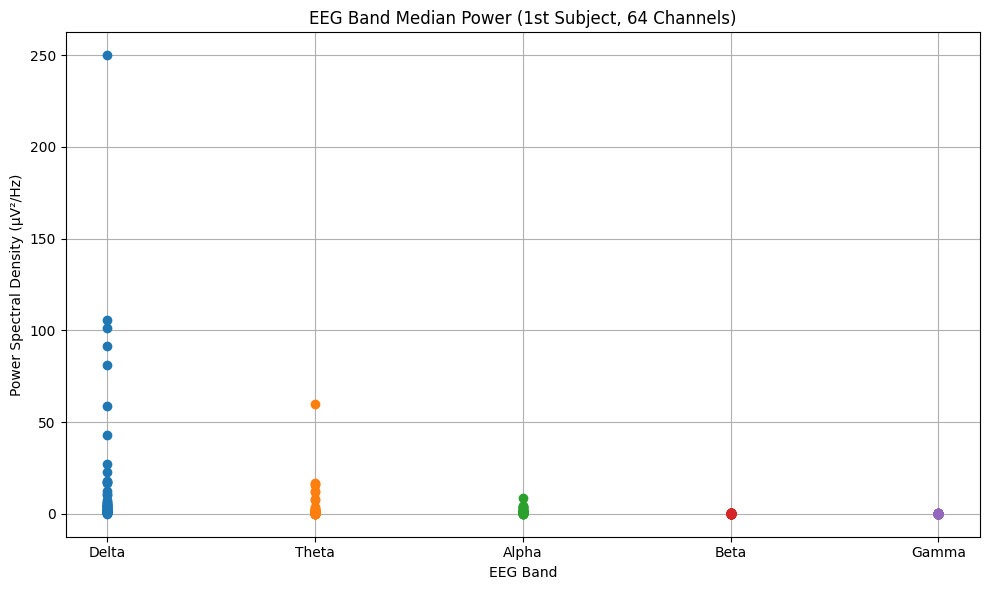

In [13]:
# 첫 번째 데이터 전처리 후 시각화하여 분포 확인

fs = 256  # 샘플링 주기 (Hz)
nperseg = 256
sample = train_input_data[0]  

# 뇌파 주파수 대역 정의
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta':  (14, 31),
    'Gamma': (31, 46)
}

band_medians = {band: [] for band in bands}

for ch in range(64):
    signal = sample[:, ch]
    freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=nperseg)

    for band, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs < high))
        median_val = np.median(psd[idx])
        band_medians[band].append(median_val)

# 시각화: 각 주파수 대역별로 64채널의 중앙값을 plot
plt.figure(figsize=(10, 6))
for band, values in band_medians.items():
    plt.plot([band]*64, values, 'o', label=band)

plt.title("EEG Band Median Power (1st Subject, 64 Channels)")
plt.ylabel("Power Spectral Density (μV²/Hz)")
plt.xlabel("EEG Band")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
def extract_eeg_features(input_data, fs=256, nperseg=256):
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 14),
        'Beta':  (14, 31),
        'Gamma': (31, 46)
    }
    
    num_subjects = input_data.shape[0]
    num_channels = input_data.shape[2]
    
    preprocessed_features = []
    
    for subj in range(num_subjects):
        subject_features = []
        for ch in range(num_channels):
            signal = input_data[subj, :, ch]
            freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=nperseg)
            
            band_medians = []
            for low, high in bands.values():
                idx = np.where((freqs >= low) & (freqs < high))
                median_val = np.median(psd[idx])
                band_medians.append(median_val)
            subject_features.append(band_medians)
        preprocessed_features.append(subject_features)
        
    return np.array(preprocessed_features)

train_input_prep = extract_eeg_features(train_input_data)
test_input_prep = extract_eeg_features(test_input_data)

In [16]:
# SVM 분류를 위해 3차원 배열을 2차원 배열로 변환

print("train data 변환 전 :", train_input_prep.shape)
print("test data 변환 전 :", test_input_prep.shape)

test_input_prep2 = test_input_prep.reshape(120,320)
train_input_prep2 = train_input_prep.reshape(1080,320)

print("train data 변환 후 :", train_input_prep2.shape)
print("test data 변환 후 :", test_input_prep2.shape)

train data 변환 전 : (1080, 64, 5)
test data 변환 전 : (120, 64, 5)
train data 변환 후 : (1080, 320)
test data 변환 후 : (120, 320)


In [17]:
# StandardScaler으로 정규화
std = StandardScaler()

train_input_scaled = std.fit_transform(train_input_prep2)
test_input_scaled = std.transform(test_input_prep2)

# Model Training

In [18]:
# train-test분리
X_train, X_test, y_train, y_test = train_test_split(train_input_prep2, train_label_data, test_size=0.2, random_state=42)

In [24]:
svm_clf = SVC(random_state=100, C=0.4, kernel='linear')

svm_clf.fit(X_train, y_train)

,C,0.4
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [25]:
y_pred = svm_clf.predict(X_test)
print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.9907407407407407
0.9444444444444444


# Results

In [26]:
# 정확도 및 주요 지표 출력
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')  # 다중 분류면 'macro'
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.9444
Precision: 0.9667
Recall   : 0.9062
F1 Score : 0.9355


In [27]:
# 전체 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9286    0.9750    0.9512       120
         1.0     0.9667    0.9062    0.9355        96

    accuracy                         0.9444       216
   macro avg     0.9476    0.9406    0.9434       216
weighted avg     0.9455    0.9444    0.9442       216



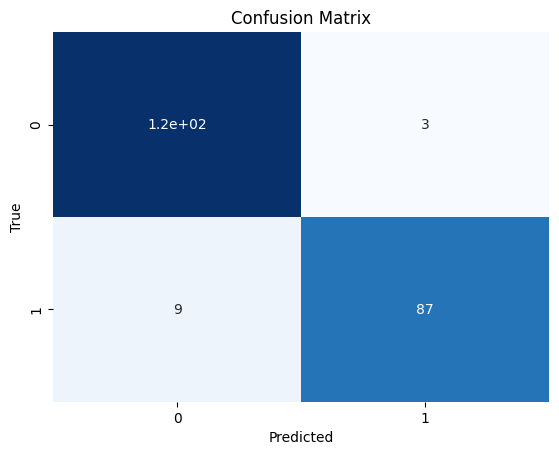

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prediction

In [29]:
prediction = svm_clf.predict(test_input_scaled)

In [30]:
id_array = np.array(range(120))
pred_array = [id_array, prediction]
pred_array = np.transpose(pred_array)

In [31]:
df = pd.DataFrame(pred_array)
df.columns = ['ID', 'Target']

In [32]:
df.to_csv('SVM classifier.csv', index=False, header=1)

In [33]:
pd.read_csv("SVM classifier.csv")

,ID,Target
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
...,...,...
115,115.0,0.0
116,116.0,0.0
117,117.0,0.0
118,118.0,0.0
